# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import glob
import matplotlib.pyplot as plt
import math
import cv2


%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Importing Data

In [3]:
data_nail = pd.read_excel("merged_data.xlsx", sheet_name="nail")
data_tongue = pd.read_excel("merged_data.xlsx", sheet_name="tongue")
data_palm = pd.read_excel("merged_data.xlsx", sheet_name="palm")
common_ids = pd.read_excel("merged_data.xlsx", sheet_name="common_ids")

In [4]:
train, test = train_test_split(common_ids, test_size=0.3)
train, test = train["number"].tolist(), test["number"].tolist()

In [5]:
nail_train, nail_test = data_nail[data_nail['number'].isin(train)], data_nail[data_nail['number'].isin(test)]
tongue_train, tongue_test = data_tongue[data_tongue['number'].isin(train)], data_tongue[data_tongue['number'].isin(test)]
palm_train, palm_test = data_palm[data_palm['number'].isin(train)], data_palm[data_palm['number'].isin(test)]

## Nail

In [6]:
X_nail_train = nail_train.drop(columns=['number','label']).to_numpy()
X_nail_test = nail_test.drop(columns=['number','label']).to_numpy()

## Tongue

In [7]:
X_tongue_train = tongue_train.drop(columns=['number','label']).to_numpy()
X_tongue_test = tongue_test.drop(columns=['number','label']).to_numpy()

## Palm

In [8]:
X_palm_train = palm_train.drop(columns=['number','label']).to_numpy()
X_palm_test = palm_test.drop(columns=['number','label']).to_numpy()

## Labels

In [9]:
y_train = nail_train['label'].to_numpy()
y_test = nail_test['label'].to_numpy()

# Helper Functions

In [10]:
def predict(X,beta,b):
    return np.dot(X,beta) + b

In [11]:
def loss(y_true,y_hat,y_pred,coeff,mse):
    
    y_nail, y_tongue, y_palm = y_pred
    a, b, c = coeff
    mse_nail, mse_tongue, mse_palm = mse

    cost = mean_squared_error(y_true, y_hat) + a*mse_nail + b*mse_tongue + c*mse_palm

    return cost

In [12]:
def gradients(y_true,y_hat,weights,coeff,X,intercept):

    weights_nail, weights_tongue, weights_palm = weights
    b_nail, b_tongue, b_palm = intercept
    X_nail, X_tongue, X_palm = X
    a, b, c = coeff
    
    y_pred_nail = predict(X_nail_train, beta_nail, b_nail)
    y_pred_tongue = predict(X_tongue_train, beta_tongue, b_tongue)
    y_pred_palm = predict(X_palm_train, beta_palm, b_palm)

    N = X_nail.shape[0]

    dw_nail = (-2*a)*np.dot(X_nail.T,2*y_true-y_hat-y_pred_nail)/N
    dw_tongue = (-2*b)*np.dot(X_tongue.T,2*y_true-y_hat-y_pred_tongue)/N
    dw_palm = (-2*c)*np.dot(X_palm.T,2*y_true-y_hat-y_pred_palm)/N

    db_nail = (-2*a/N)*np.sum(2*y_true-y_hat-y_pred_nail)
    db_tongue = (-2*b/N)*np.sum(2*y_true-y_hat-y_pred_tongue)
    db_palm = (-2*c/N)*np.sum(2*y_true-y_hat-y_pred_palm)

    da = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_nail) + np.dot(y_pred_nail,y_pred_nail) - np.dot(y_hat,y_pred_nail))/N
    db = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_tongue) + np.dot(y_pred_tongue,y_pred_tongue) - np.dot(y_hat,y_pred_tongue))/N
    dc = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_palm) + np.dot(y_pred_palm,y_pred_palm) - np.dot(y_hat,y_pred_palm))/N

    return [dw_nail, dw_tongue, dw_palm, db_nail, db_tongue, db_palm, da, db, dc]

In [13]:
def sq_sum(a,b,c):
    return math.sqrt(a**2 + b**2 + c**2)

# Driver Code

## Initilisation 

In [132]:
a, b, c = 2.0, 1.0, 3.0

features = X_nail_train.shape[1]
rows = X_nail_train.shape[0]

beta_nail = np.array([0.01]*features)
b_nail = 1.0

beta_tongue = np.array([0.02]*features)
b_tongue = 1.0

beta_palm = np.array([0.001]*features)
b_palm = 1.0

train_loss = []

alpha = 0.0000001
iterations = 500

print(f"Shape of training data is {X_nail_train.shape}")

Shape of training data is (182, 14)


## Training

Training Complete


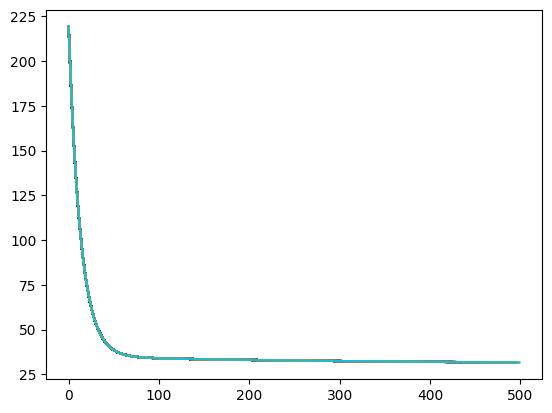

In [133]:
for i in range(iterations):

    # print(f"-----------------------------------------------------------------------------------------")
    # print(f"Iteration {i+1}")

    
    # PREDICTION
    y_pred_nail = predict(X_nail_train, beta_nail, b_nail)
    y_pred_tongue = predict(X_tongue_train, beta_tongue, b_tongue)
    y_pred_palm = predict(X_palm_train, beta_palm, b_palm)

    # print(f"actual prediction = {y_train}")    
    # print(f"beta coeff of nail = {beta_nail}")
    # print(f"prediction of tongue = {y_pred_tongue}")
    # print(f"prediction of palm = {y_pred_palm}")

    
    # MEAN SQUARED ERROR
    mse_nail = mean_squared_error(y_train, y_pred_nail)
    mse_tongue = mean_squared_error(y_train, y_pred_tongue)
    mse_palm = mean_squared_error(y_train, y_pred_palm)

    # print(f"mse of nail = {mse_nail}")
    # print(f"mse of tongue = {mse_tongue}")
    # print(f"mse of palm = {mse_palm}")

    
    # SUM OF SQUARES OF COEFF = 1
    denom = sq_sum(a,b,c)
    a, b, c = a/denom, b/denom, c/denom

    
    # FINAL PREDICTION
    y_hat = a*y_pred_nail + b*y_pred_tongue + c*y_pred_palm
    # print(f"prediction = {y_hat}")
    # print(f"mse overall = {mean_squared_error(y_train, y_hat)}")

    
    # LOSS FUNCTION ATTRIBUTES
    y_pred = [y_pred_nail, y_pred_tongue, y_pred_palm]
    coeff = [a, b, c]
    weights = [beta_nail, beta_tongue, beta_palm]
    mse = [mse_nail, mse_tongue, mse_palm]
    X = [X_nail_train, X_tongue_train, X_palm_train]
    intercept = [b_nail, b_tongue, b_palm]

    
    # LOSS FUNCTION
    train_loss.append(loss(y_train,y_hat,y_pred,coeff,mse))
    plt.plot(train_loss)
    
    # GRADIENTS
    dw = gradients(y_train,y_hat,weights,coeff,X,intercept)
    dw_nail, dw_tongue, dw_palm, db_nail, db_tongue, db_palm, da, db, dc = dw

    
    # UPDATING PARAMETERS
    beta_nail -= alpha*dw_nail
    beta_tongue -= alpha*dw_tongue
    beta_palm -= alpha*dw_palm
    
    b_nail -= alpha*db_nail
    b_tongue -= alpha*db_tongue
    b_palm -= alpha*db_palm
    
    a -= alpha*da 
    b -= alpha*db 
    c -= alpha*dc

    # SUM OF SQUARES OF COEFF = 1
    denom = sq_sum(a,b,c)
    a, b, c = a/denom, b/denom, c/denom

print("Training Complete")

In [134]:
print(train_loss[-5:])

[31.685605504926485, 31.68251807526385, 31.67943870698266, 31.67636737578935, 31.673304057481637]


In [135]:
print(f"beta coeff of nail = {beta_nail}")    
print(f"-----------------------------------------------------------------------------------------")
print(f"beta coeff of tongue = {beta_tongue}")
print(f"-----------------------------------------------------------------------------------------")
print(f"beta coeff of palm = {beta_palm}")

beta coeff of nail = [0.00594871 0.00725654 0.00752485 0.00869581 0.00998009 0.00655122
 0.00689182 0.00842578 0.00840768 0.00932705 0.00902814 0.00689182
 0.00810066 0.0099427 ]
-----------------------------------------------------------------------------------------
beta coeff of tongue = [ 0.0091151   0.01351239  0.01306208  0.01560262  0.01994349 -0.00492514
  0.01203414  0.01678219  0.01687501  0.01788032  0.01728114  0.01203414
  0.01622282  0.01993   ]
-----------------------------------------------------------------------------------------
beta coeff of palm = [0.00610716 0.00420972 0.00491094 0.00289972 0.00103351 0.00177097
 0.00485118 0.00189684 0.0018431  0.00186645 0.00211952 0.00485118
 0.00174751 0.00095361]


In [136]:
print(f"intercept coeff of nail = {b_nail}")
print(f"intercept coeff of tongue = {b_tongue}")
print(f"intercept coeff of palm = {b_palm}")

intercept coeff of nail = 0.9999799916818572
intercept coeff of tongue = 0.999938718214614
intercept coeff of palm = 1.0000292146430245


In [137]:
print(f"coeff of nail = {a}")
print(f"coeff of tongue = {b}")
print(f"coeff of palm = {c}")

coeff of nail = 0.5370621565022234
coeff of tongue = 0.27966383527874766
coeff of palm = 0.7958343918745674


# Testing

In [138]:
print(f"Shape of training data is {X_nail_test.shape}")

Shape of training data is (78, 14)


In [139]:
y_pred_nail = predict(X_nail_test, beta_nail, b_nail)
y_pred_tongue = predict(X_tongue_test, beta_tongue, b_tongue)
y_pred_palm = predict(X_palm_test, beta_palm, b_palm)

denom = sq_sum(a,b,c)
a, b, c = a/denom, b/denom, c/denom

In [140]:
y_test
y_hat_test = a*y_pred_nail + b*y_pred_tongue + c*y_pred_palm

In [141]:
mean_squared_error(y_test, y_hat_test)

13.036939935666181

In [142]:
mean_absolute_error(y_test, y_hat_test)

3.1076688210322883

In [143]:
r2_score(y_test, y_hat_test)

-2.2033436401039004

In [ ]:
y_pred_nail = predict(X_nail_train, beta_nail, b_nail)
y_pred_tongue = predict(X_tongue_train, beta_tongue, b_tongue)
y_pred_palm = predict(X_palm_train, beta_palm, b_palm)

In [ ]:
mse_nail = mean_squared_error(y_train, y_pred_nail)
mse_tongue = mean_squared_error(y_train, y_pred_tongue)
mse_palm = mean_squared_error(y_train, y_pred_palm)

In [ ]:
denom = sq_sum(a,b,c)
a, b, c = a/denom, b/denom, c/denom

In [ ]:
y_hat = a*y_pred_nail + b*y_pred_tongue + c*y_pred_palm

In [ ]:
y_pred = [y_pred_nail, y_pred_tongue, y_pred_palm]
coeff = [a, b, c]
weights = [beta_nail, beta_tongue, beta_palm]
mse = [mse_nail, mse_tongue, mse_palm]
train_loss.append(loss(y_train,y_hat,y_pred,coeff,mse))

X = [X_nail_train, X_tongue_train, X_palm_train]
intercept = [b_nail, b_tongue, b_palm]

In [ ]:
dw = gradients(y_train,y_hat,weights,coeff,X,intercept)
dw_nail, dw_tongue, dw_palm, db_nail, db_tongue, db_palm, da, db, dc = dw

beta_nail -= alpha*dw_nail
beta_tongue -= alpha*dw_tongue
beta_palm -= alpha*dw_palm

b_nail -= alpha*db_nail
b_tongue -= alpha*db_tongue
b_palm -= alpha*db_palm

a -= alpha*da 
b -= alpha*db 
c -= alpha*dc 